# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)  Project 4: Web Scraping Job Postings

## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

---

## Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to answer the two questions described above.




### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

---

## Requirements

1. Scrape and prepare your own data.

2. **Create and compare at least two models for each section**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).
   - Section 1: Job Salary Trends
   - Section 2: Job Category Factors

3. Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists. 
   - Make sure to clearly describe and label each section.
   - Comment on your code so that others could, in theory, replicate your work.

4. A brief writeup in an executive summary, written for a non-technical audience.
   - Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.



## Suggestions for Getting Started

1. Collect data from [Indeed.com](www.indeed.com) (or another aggregator) on data-related jobs to use in predicting salary trends for your analysis.
  - Select and parse data from *at least 1000 postings* for jobs, potentially from multiple location searches.
2. Find out what factors most directly impact salaries (e.g. title, location, department, etc).
  - Test, validate, and describe your models. What factors predict salary category? How do your models perform?
3. Discover which features have the greatest importance when determining a low vs. high paying job.
  - Your Boss is interested in what overall features hold the greatest significance.
  - HR is interested in which SKILLS and KEY WORDS hold the greatest significance.   
4. Author an executive summary that details the highlights of your analysis for a non-technical audience.
5. If tackling the bonus question, try framing the salary problem as a classification problem detecting low vs. high salary positions.

---

## Useful Resources

- Scraping is one of the most fun, useful and interesting skills out there. Don’t lose out by copying someone else's code!
- [Here is some advice on how to write for a non-technical audience](http://programmers.stackexchange.com/questions/11523/explaining-technical-things-to-non-technical-people)
- [Documentation for BeautifulSoup can be found here](http://www.crummy.com/software/BeautifulSoup/).

---

### Project Feedback + Evaluation

For all projects, students will be evaluated on a simple 3 point scale (0, 1, or 2). Instructors will use this rubric when scoring student performance on each of the core project **requirements:** 

Score | Expectations
----- | ------------
**0** | _Does not meet expectations. Try again._
**1** | _Meets expectations. Good job._
**2** | _Surpasses expectations. Brilliant!_

[For more information on how we grade our DSI projects, see our project grading walkthrough.](https://git.generalassemb.ly/dsi-projects/readme/blob/master/README.md)


# The Biz

In [2]:
from bs4 import BeautifulSoup
import requests
import re
from fake_useragent import UserAgent

from selenium import webdriver
from time import sleep
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from xlsxwriter import Workbook
import os

import requests
import shutil

import math
import numpy as np
import pandas as pd

### We shall search jobs by term : 'Analytics' as it returns 1000+ search results

In [3]:
""" DO NOT RUN!!!! UNLESS U WANNA SCRAP FOR 4 HRS"""

# Create table
columns = ['Title','Company','Location','Range','Monthly/Annual','Seniority','JD','Req','Industry']
cf_df = pd.DataFrame(columns=columns)

# Go to URL
driver = webdriver.Chrome(r'C:\Users\Zach\Downloads\chromedriver_win32\chromedriver')
url = 'https://www.mycareersfuture.sg/'
driver.get(url)


sleep(1)

# search data jobs
search_bar = driver.find_element_by_id("search-text")
search_param = 'analytics'
search_bar.send_keys(search_param)
sleep(1)
search_bar.send_keys(Keys.RETURN)

sleep(5)

num_of_results = driver.find_element_by_xpath("//span[@id='search-results-message']/div").text.split()[0]
num_of_results = int(num_of_results.replace(',',''))
num_of_pages = math.ceil(num_of_results/20)

print('Number of Results:',num_of_results)
print('Number of Pages',num_of_pages)


try:
    x_button = driver.find_element_by_xpath("//div[@id='snackbar']//span[@type='action']")
    x_button.click()
except:
    pass

for page_num in range(num_of_pages):
    
    page_url = 'https://www.mycareersfuture.sg/search?search={}&sortBy=new_posting_date&page={}'.format(search_param,page_num)
    driver.get(page_url)
    try:
        x_button = driver.find_element_by_xpath("//div[@id='snackbar']//span[@type='action']")
        x_button.click()
    except:
        pass
    try:
        close_add_skill = driver.find_element_by_xpath("//div[@id='page-search-results']//button[@class='joyride-tooltip__close']")
        close_add_skill.click() 
    except:
        pass

    for i in range(20):
    
        sleep(3)
        
        x_path ="//div[@id='job-card-{}']//a[@class='bg-white mb3 w-100 dib v-top pa3 no-underline flex-ns flex-wrap JobCard__card___22xP3']".format(i%20)
        job_link= driver.find_element_by_xpath(x_path).get_attribute('href')
        
        # Switch control 
        driver2 = webdriver.Chrome(r'C:\Users\Zach\Downloads\chromedriver_win32\chromedriver')
        driver2.get(job_link)

        sleep(5)
        
        # Title
        try:
            job_title = driver2.find_element_by_xpath("//h1[@id='job_title']").text
        except:
            job_title = 'undisclosed'
        # company name
        try:    
            company_name = driver2.find_element_by_xpath("//section[@id='job_details']//p[@name='company']").text
        except:
            company_name = 'undisclosed'
        #location
        try:
            job_loc = driver2.find_element_by_xpath("//p[@id='address']").text
        except:
            job_loc = 'undisclosed'
        # Salary Range
        try:
            salary_range = driver2.find_element_by_class_name("lh-solid").text
        except:
            salary_range = 'undisclosed'
        
        # Annual or Monthly
        try:
            period_salary = driver2.find_element_by_class_name("salary_type").text
        except:
            period_salary = 'undisclosed'
        #Seniority
        try:
            seniority = driver2.find_element_by_id("seniority").text
        except:
            seniority = 'undisclosed'
        # Req
        try:
            requirements = driver2.find_element_by_id ("requirements").text
        except:
            requirements ='undisclosed'
        # JD
        try:
            job_descr = driver2.find_element_by_xpath("//div [@id ='content']").text
        except:
            job_descr = 'undisclosed'
        #sector
        try:
            industry = driver2.find_element_by_xpath("//p [@id ='job-categories']").text
        except:
            industry = 'undislosed'
            
        new_row= {'Title':job_title,
            'Company':company_name,
            'Location':job_loc,
            'Range':salary_range,
            'Monthly/Annual':period_salary,
            'Seniority':seniority,
            'Industry':industry,
            'JD': job_descr,
            'Req':requirements}
        
        cf_df = cf_df.append(new_row,ignore_index=True)
        # Driver2 close
        driver2.close()



Number of Results: 1035
Number of Pages 52


In [4]:
cf_df

,Title,Company,Location,Range,Monthly/Annual,Seniority,JD,Req,Industry
0,Delivery Lead – Singapore (PACE Analytics),RIO TINTO SINGAPORE HOLDINGS PTE. LTD.,undisclosed,"$13,000to$17,000",Monthly,Manager,Delivery Lead – Singapore (PACE Analytics)\nGr...,Requirements\nAbout you\nTo be successfully co...,Information Technology
1,"VP / AVP, Machine Learning Engineer, Group Con...",DBS BANK LTD.,undisclosed,"$7,000to$14,000",Monthly,"Middle Management, Manager",Job Purpose \n Build and improve machine lear...,Requirements\nPhD/Masters/Bachelors in Compute...,Banking and Finance
2,"VP / AVP, Senior Data Engineer, Group Consumer...",DBS BANK LTD.,undisclosed,"$7,000to$14,000",Monthly,"Middle Management, Manager",Design and implement key components for highly...,Requirements\nExperience in big data and machi...,Banking and Finance
3,"VP / AVP, Sr. Frontend Developer, Group Consum...",DBS BANK LTD.,undisclosed,"$6,500to$15,000",Monthly,"Middle Management, Manager",Key Accountabilities\nDBS Consumer Banking and...,Requirements\n7+ years professional applicatio...,Banking and Finance
4,Research Scientist - Energy Systems,GLOBESOFT SERVICES PTE. LTD.,"SHENTON HOUSE, 3 SHENTON WAY 068805","$6,000to$8,000",Monthly,Professional,Research Scientist - Data Analytics for Energy...,Requirements\nYour role: \nDesign and developm...,Sciences / Laboratory / R&D
5,MHA Science & Technology Associate Programme,MINISTRY OF HOME AFFAIRS,"NEW PHOENIX PARK, 28 IRRAWADDY ROAD 329560",undisclosed,,Fresh/entry level,MHA S&T Associate Programme\nThe Ministry of H...,undisclosed,"Information Technology, Public / Civil Service"
6,International Business Analyst,SCHNEIDER ELECTRIC IT LOGISTICS ASIA PACIFIC P...,50 KALLANG AVENUE 339505,"$4,500to$8,000",Monthly,Senior Executive,This position provides visibility to the busin...,Requirements\nUniversity degree with focus on ...,Consulting
7,"IT Security Analyst (VPN, Firewall, Proxy, Dat...",TECHCOM SOLUTIONS & CONSULTANCY PTE. LTD.,"SHENTON HOUSE, 3 SHENTON WAY 068805","$5,500to$7,000",Monthly,Middle Management,"Hands on experience on Firewall, VPN, Proxy (f...",Requirements\nMinimum of 5 years of experience...,"Banking and Finance, Information Technology"
8,Senior Manager / Manager / Senior Consultant,DELOITTE & TOUCHE ENTERPRISE RISK SERVICES PTE...,"OUE DOWNTOWN, 6 SHENTON WAY 068809","$4,500to$10,000",Monthly,Manager,You will work with clients to assess and impro...,Requirements\nThe successful candidate should ...,Risk Management
9,Senior Manager / Manager / Senior Consultant,DELOITTE & TOUCHE ENTERPRISE RISK SERVICES PTE...,"OUE DOWNTOWN, 6 SHENTON WAY 068809","$4,500to$10,000",Monthly,Manager,You will work with clients to assess and impro...,Requirements\nThe successful candidate should ...,Risk Management


In [14]:
cf_df.to_csv('analyticsfinal.csv',header=columns, index=False)

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
analytics = pd.read_csv('analyticsfinal.csv')

In [4]:
analytics.shape

(1040, 9)

In [5]:
analytics.dtypes

Title             object
Company           object
Location          object
Range             object
Monthly/Annual    object
Seniority         object
JD                object
Req               object
Industry          object
dtype: object

In [6]:
analytics.columns

Index(['Title', 'Company', 'Location', 'Range', 'Monthly/Annual', 'Seniority',
       'JD', 'Req', 'Industry'],
      dtype='object')

In [7]:
# drop indices that are 'undisclosed' salary
analytics.drop(index=analytics[analytics.Range == 'undisclosed'].index, inplace=True)

In [8]:
analytics.shape

(921, 9)

In [9]:
#cleanup the salary range column
analytics.Range = analytics.Range.str.replace('$','')
analytics.Range = analytics.Range.str.replace(',','')
analytics.Range = analytics.Range.str.split('to')

In [10]:
analytics['min_salary'] = analytics.Range.map(lambda x:x[0]).astype(float)

In [11]:
analytics['max_salary'] = analytics.Range.map(lambda x:x[1]).astype(float)

In [12]:
analytics['expected_salary'] = (analytics['min_salary'] + analytics['max_salary'])/2

In [13]:
analytics['Monthly_expected_salary'] = analytics[analytics['Monthly/Annual'] == 'Annually']['expected_salary'].apply(lambda x:(x//12))

In [14]:
# expected monthly salary for those that are monthly 
analytics['Monthly_expected_salary'].fillna(analytics['expected_salary'],inplace=True)

In [15]:
analytics.columns

Index(['Title', 'Company', 'Location', 'Range', 'Monthly/Annual', 'Seniority',
       'JD', 'Req', 'Industry', 'min_salary', 'max_salary', 'expected_salary',
       'Monthly_expected_salary'],
      dtype='object')

In [16]:
# drop those that we dont need
analytics.drop (columns=['Range','Monthly/Annual','expected_salary'],inplace=True)

In [17]:
analytics.Industry.value_counts().head()

Information Technology          325
Banking and Finance              82
Sciences / Laboratory / R&D      76
Marketing / Public Relations     40
Consulting                       38
Name: Industry, dtype: int64

In [18]:
# check for null values
analytics.isnull().sum()

Title                      0
Company                    0
Location                   0
Seniority                  0
JD                         0
Req                        0
Industry                   0
min_salary                 0
max_salary                 0
Monthly_expected_salary    0
dtype: int64

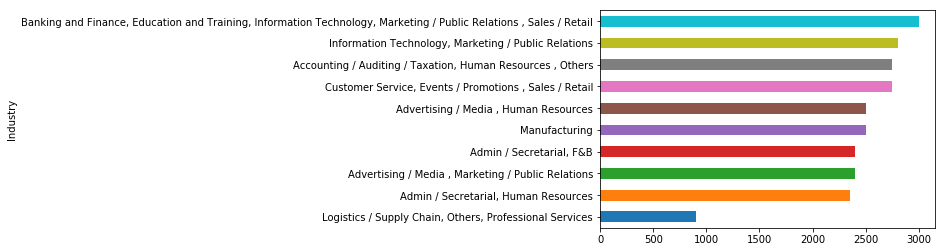

In [19]:
# can see that the 'Industry' tab is very ...... messy..
analytics.groupby('Industry')['Monthly_expected_salary'].median().sort_values().head(10).plot(kind='barh')

325

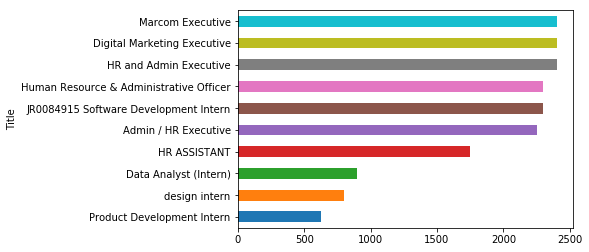

In [21]:
analytics.groupby('Title')['Monthly_expected_salary'].median().sort_values().head(10).plot(kind='barh')

In [80]:
len(analytics[analytics.Title.str.contains('Data|scientist')])

173

C:\Users\Zach\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 20000)

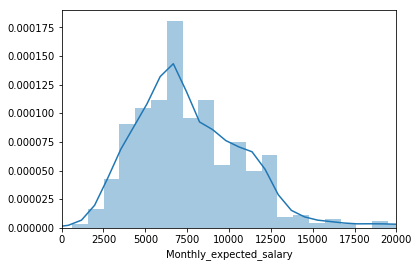

In [22]:
sns.distplot(analytics.Monthly_expected_salary,norm_hist=True, bins = 100)
plt.xlim(0,20000)

In [29]:
### Job description and requirement sections

In [33]:
# clean up the JD and req column
analytics.JD = analytics.JD.str.replace('\r\n',' ')
analytics.Req = analytics.Req.str.replace('\r\n',' ')

In [71]:
len(analytics[analytics.JD.str.contains('analytics|machine learning|data science|data engineer|ML|AI|analyst')])

775

### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.


#### BONUS

5. Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.

6. Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

---